# Intro to Geometric Deep Learning
## by Logan Cerkovnik 

## Agenda
- Intro to Graph Theory 
- Why Deep Learning for Graphs?
- Use Cases for Geometric Deep Learning 
- Intro to Pytorch Geometric 
- Pytorch Geometric Examples 
- Questions/Feedback 

### Intro to Graph Theory / Network Analysis 
- Graphs are a way of modeling discrete relationships between discrete objects as nodes and edges  
- Examples of graph networks you already know: Social Networks( Facebook, LinkedIn), Communication Networks,  Citation Networks, Biological Networks( Protein/RNA/DNA Interaction Networks)
- Libraries for doing classing network analysis (NetworkX python, iGraph R,Python)
- Graph Databases ( Neo4j, OrientDB ) , Graph queries ( graphql ) 
- Graph Visualization Tools: Gephi
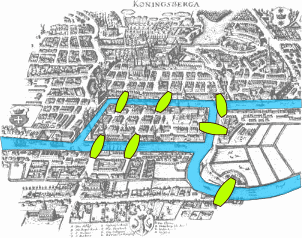

### Types of Graphs
- Directed or Undirected: Does the order of the connections from one node to another matter 
- weighted edges: Do the connections between nodes vary in their strength?
- weighted nodes: Do the nodes have varying strength or varying properties?
- self-connections: Can nodes connect to themselves?
#### The goal of this analysis is to choose a graph structure that accurately depicts the relationships 
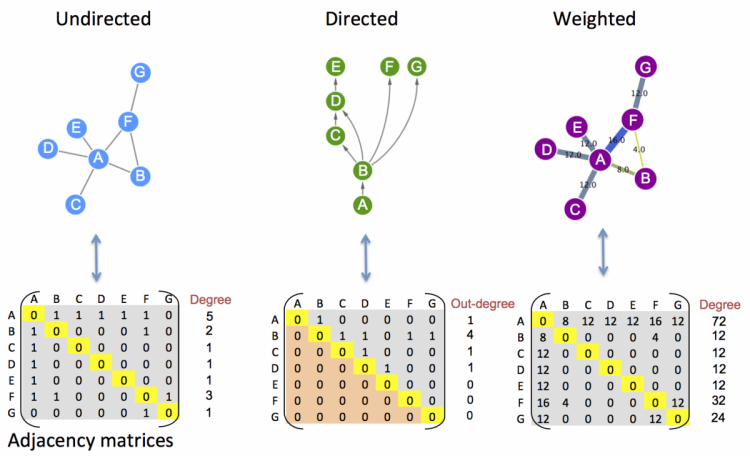

### Some Types of Graph / Network Analysis 
- Centrality Analysis or Predictions of Node / Node Properties: ex "brand influencers, ranking internet pages" 
- Prediction of Edges: / Links: ex: "recommendation engine, people you may know "
- Community Analysis( Clustering): ex "scientific communities, ecological communities , social hierarchy "
- Network Regression/ Classification: ex " given a network as input give classification or regression"
- Dynamic Network Analysis : ex "disease spreading  or temporal phenomonon transfered through network"
- Network Generation: ex "generation of new chemical compounds for drug discovery"

### Why are Graphs Challenging to Work With?
- Turning Graphs into Matrixes is Tricky 
- Loops and Weird Shapes can be challenging to work with 
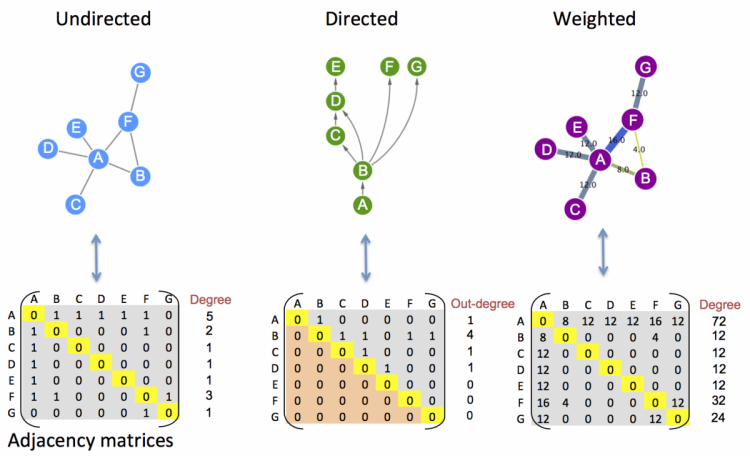


### Why Deep Learning for Graphs?
- Using machine learning in graph analysis without deep learning will often result in taking traditional graph analysis metrics for nodes and edges in a tabular form to create features 
- many traditional metrics especially centrality ones are highly correlated with each other, require hyperparameters set for a given feature, don't scale well with large graph edges/nodes ,and are computationally demanding.
- Similar to Image Analysis/ NLP before Deep Learning where handcrafted features were predominately used


### Geometric Deep Learning Use Cases
- Data that comes from real world graph network
- Dimensionality Reduction - T-SNE auto encoder alternative for manifold learning 
- Image data where geometry of objects in the image is really important ( 3d meshes, medical images) 


### Making Graphs Easier to Work With in Torch
- torch_scatter: optimized sparse reduce operations 
- torch-unique: optimized unique functionality
- torch-geometric: pytorch-based library for deep learning for graphs and manifolds 

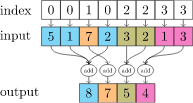

https://github.com/rusty1s/pytorch_geometric


### Installation 
- pip install cffi
- pip install --upgrade torch-scatter
- pip install --upgrade torch-unique
- pip install --upgrade torch-cluster
- pip install --upgrade torch-spline-conv
- pip install torch-geometric

In [1]:
import os.path as osp
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import AGNNProp, SplineConv, GATConv, GCNConv, ChebConv 
from torch_geometric.datasets import Planetoid
import pandas as pd
dataset = Planetoid(root='/tmp/Cora', name='Cora')

Processing...
Done!


In [2]:
dataset = Planetoid(root='/tmp/Cora', name='Cora', transform= T.NormalizeFeatures())
data = dataset[0]

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(data.num_features, 16)
        self.prop1 = AGNNProp(requires_grad=False)
        self.prop2 = AGNNProp(requires_grad=True)
        self.fc2 = torch.nn.Linear(16, data.num_classes)

    def forward(self):
        x = F.dropout(data.x, training=self.training)
        x = F.relu(self.fc1(x))
        x = self.prop1(x, data.edge_index)
        x = self.prop2(x, data.edge_index)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [3]:
def train():
    model.train()
    optimizer.zero_grad()
    F.nll_loss(model()[data.train_mask], data.y[data.train_mask]).backward()
    optimizer.step()


def test():
    model.eval()
    logits, accs = model(), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

val_loss = []
for epoch in range(1, 101):
    train()
    log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
#     print(log.format(epoch, *test()))
    val_loss.append(test())

net_df = pd.DataFrame.from_records(val_loss , columns = ['Train_Loss', 'Val_Loss', 'Test_Loss'] )
net_df = net_df[['Train_Loss', 'Test_Loss']]
net_df['Network'] = 'AGNNProp'

all_df = net_df

In [4]:

data = Planetoid(root = '/tmp/Cora', name='Cora', transform= T.TargetIndegree())[0]

data.train_mask = torch.zeros(data.num_nodes, dtype=torch.uint8)
data.train_mask[:data.num_nodes - 1000] = 1
data.val_mask = None
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.uint8)
data.test_mask[data.num_nodes - 500:] = 1


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = SplineConv(data.num_features, 16, dim=1, kernel_size=2)
        self.conv2 = SplineConv(16, data.num_classes, dim=1, kernel_size=2)

    def forward(self):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = F.dropout(x, training=self.training)
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        return F.log_softmax(x, dim=1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)

val_loss = []
for epoch in range(1, 201):
    train()
    log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
#     print(log.format(epoch, *test()))
    val_loss.append(test())
    
net_df = pd.DataFrame.from_records(val_loss , columns = ['Train_Loss', 'Test_Loss'] )
net_df['Network'] = 'SplineConv'
all_df = pd.concat([all_df, net_df], axis = 0)

In [5]:
data = Planetoid(root = '/tmp/Cora', name='Cora', transform= T.NormalizeFeatures())[0]

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.att1 = GATConv(data.num_features, 8, heads=8, dropout=0.6)
        self.att2 = GATConv(8 * 8, data.num_classes, dropout=0.6)

    def forward(self):
        x = F.dropout(data.x, p=0.6, training=self.training)
        x = F.elu(self.att1(x, data.edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.att2(x, data.edge_index)
        return F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

val_loss = []
for epoch in range(1, 201):
    train()
    log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
#     print(log.format(epoch, *test()))
    val_loss.append(test())
    
net_df = pd.DataFrame.from_records(val_loss , columns = ['Train_Loss', 'Val_Loss', 'Test_Loss'] )
net_df = net_df[['Train_Loss', 'Test_Loss']]

net_df['Network'] = 'GATConv'
all_df = pd.concat([all_df, net_df], axis = 0, sort = False )

In [6]:
data = Planetoid(root = '/tmp/Cora', name='Cora', transform= T.NormalizeFeatures())[0]

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(data.num_features, 16)
        self.conv2 = GCNConv(16, data.num_classes)
        # self.conv1 = ChebConv(data.num_features, 16, K=2)
        # self.conv2 = ChebConv(16, data.num_features, K=2)

    def forward(self):
        x = F.relu(self.conv1(data.x, data.edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, data.edge_index)
        return F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
val_loss = []
for epoch in range(1, 201):
    train()
    log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
#     print(log.format(epoch, *test()))
    val_loss.append(test())
    
net_df = pd.DataFrame.from_records(val_loss , columns = ['Train_Loss', 'Val_Loss', 'Test_Loss'] )
net_df['Network'] = 'GCNConv'
all_df = pd.concat([all_df, net_df], axis = 0)

/home/logan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [7]:
data = Planetoid(root = '/tmp/Cora', name='Cora', transform= T.NormalizeFeatures())[0]

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
#         self.conv1 = GCNConv(data.num_features, 16)
#         self.conv2 = GCNConv(16, data.num_classes)
        self.conv1 = ChebConv(data.num_features, 16, K=2)
        self.conv2 = ChebConv(16, data.num_features, K=2)

    def forward(self):
        x = F.relu(self.conv1(data.x, data.edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, data.edge_index)
        return F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
val_loss = []
for epoch in range(1, 201):
    train()
    log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
#     print(log.format(epoch, *test()))
    val_loss.append(test())
    
net_df = pd.DataFrame.from_records(val_loss , columns = ['Train_Loss', 'Val_Loss', 'Test_Loss'] )
net_df['Network'] = 'ChebConv'
net_df = net_df[['Train_Loss', 'Test_Loss']]

all_df = pd.concat([all_df, net_df], axis = 0)

/home/logan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [40]:
all_df['epoch'] = range(all_df.shape[0], 0, -1)

all_df.head()

,Network,Test_Loss,Train_Loss,Val_Loss,epoch
0,AGNNProp,0.13,0.142857,NaN,900
1,AGNNProp,0.13,0.142857,NaN,899
2,AGNNProp,0.13,0.142857,NaN,898
3,AGNNProp,0.13,0.142857,NaN,897
4,AGNNProp,0.13,0.142857,NaN,896


/home/logan/miniconda3/lib/python3.6/site-packages/plotnine/utils.py:281: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
/home/logan/.local/lib/python3.6/site-packages/pandas/core/generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/home/logan/.local/lib/python3.6/site-packages/pandas/core/generic.py:4385: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


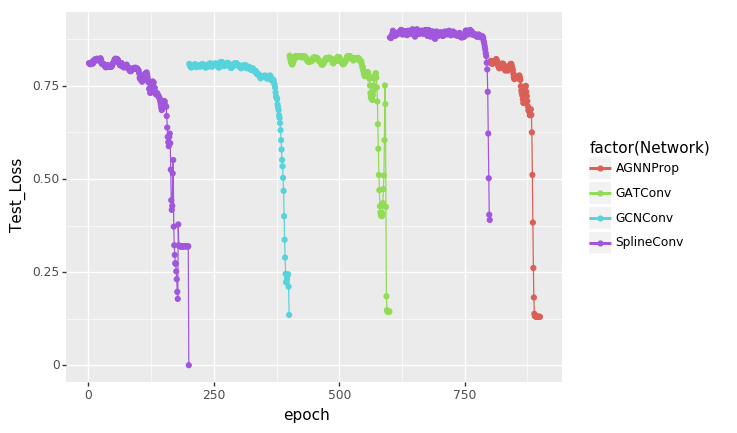

<ggplot: (-9223363245117855621)>

In [45]:
from plotnine import * 
import numpy as np
all_df['epoch'] = range(all_df.shape[0], 0, -1)
(ggplot(all_df, aes(x='epoch', y = 'Test_Loss', color='factor(Network)')) + geom_line() + geom_point() )